<a href="https://colab.research.google.com/github/musiitwa567/chatbot/blob/main/spine2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.utils import to_categorical

# Function to prepare dataset
def prepare_dataset(image_path, mask_path):
    image_files = []
    mask_files = []

    for root, _, files in os.walk(image_path):
        for file in files:
            image_files.append(os.path.join(root, file))
    
    for root, _, files in os.walk(mask_path):
        for file in files:
            mask_files.append(os.path.join(root, file))
    
    images = []
    masks = []
    
    for img_file, mask_file in zip(image_files, mask_files):
        img = Image.open(img_file).resize((48, 48))
        mask = Image.open(mask_file).resize((48, 48))
        
        img = np.array(img)
        mask = np.array(mask)
        
        images.append(img)
        masks.append(mask)
    
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks


In [3]:
from tensorflow.keras import regularizers

# U-Net architecture with L1 and L2 regularization
def unet(input_size=(None, None, 3)):
    # Encoder
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    conv2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(conv2)
    up1 = UpSampling2D(size=(2, 2))(conv2)
    concat1 = concatenate([conv1, up1], axis=3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(concat1)
    conv3 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(conv3)

    outputs = Conv2D(num_classes, 1, activation='softmax')(conv3)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [4]:
from sklearn.model_selection import train_test_split

# Set the paths to your image and mask directories
image_path = '/content/drive/MyDrive/SampleLumbarDataset/Images'
mask_path = '/content/drive/MyDrive/SampleLumbarDataset/Masks'

# Load and preprocess the dataset
images, masks = prepare_dataset(image_path, mask_path)

In [5]:
# Normalize images
images = images / 255.0

In [6]:
# Check unique class indices in masks
unique_classes = np.unique(masks)
print("Unique Class Indices:", unique_classes)


Unique Class Indices: [  0   1   4   8   9  10  11  12  13  15  16  17  18  19  23  30  31  32
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255]


In [7]:
# Convert masks to one-hot encoding
num_classes = len(unique_classes)
masks_one_hot = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2], num_classes))
for i in range(num_classes):
    masks_one_hot[:, :, :, i] = (masks == unique_classes[i]).astype(int)


In [8]:
# Split the dataset into training and validation sets
images_train, images_val, masks_train, masks_val = train_test_split(images, masks_one_hot, test_size=0.2, random_state=42)

In [9]:
# Build the U-Net model
model = unet(input_size=(48, 48, 3))

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
# Create a History object
history = tf.keras.callbacks.History()

In [12]:
# Train the model with the holdout set for validation
model.fit(images_train, masks_train, validation_data=(images_val, masks_val), epochs=50, batch_size=8, callbacks=[history])


Epoch 1/50
20/20 [==============================] - 15s 74ms/step - loss: 90.9523 - accuracy: 0.7935 - val_loss: 56.5110 - val_accuracy: 0.8883
Epoch 2/50
20/20 [==============================] - 0s 22ms/step - loss: 37.1505 - accuracy: 0.8877 - val_loss: 19.3584 - val_accuracy: 0.8883
Epoch 3/50
20/20 [==============================] - 0s 23ms/step - loss: 11.8521 - accuracy: 0.8877 - val_loss: 6.1766 - val_accuracy: 0.8883
Epoch 4/50
20/20 [==============================] - 0s 23ms/step - loss: 4.2973 - accuracy: 0.8877 - val_loss: 3.0210 - val_accuracy: 0.8883
Epoch 5/50
20/20 [==============================] - 0s 23ms/step - loss: 2.5326 - accuracy: 0.8877 - val_loss: 2.1503 - val_accuracy: 0.8883
Epoch 6/50
20/20 [==============================] - 0s 22ms/step - loss: 2.0116 - accuracy: 0.8877 - val_loss: 1.8825 - val_accuracy: 0.8883
Epoch 7/50
20/20 [==============================] - 0s 22ms/step - loss: 1.8308 - accuracy: 0.8877 - val_loss: 1.7772 - val_accuracy: 0.8883
Epoch 8

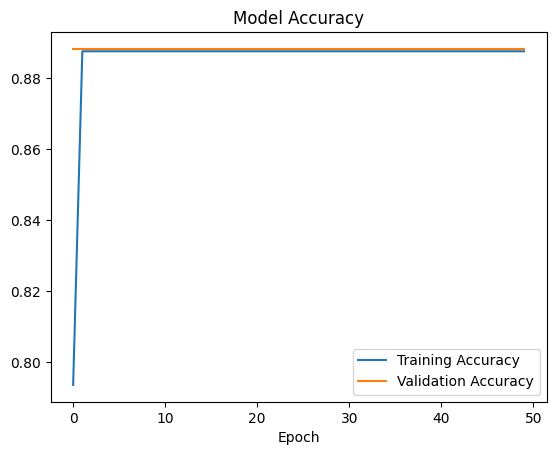

In [13]:
import matplotlib.pyplot as plt

# Plot the training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

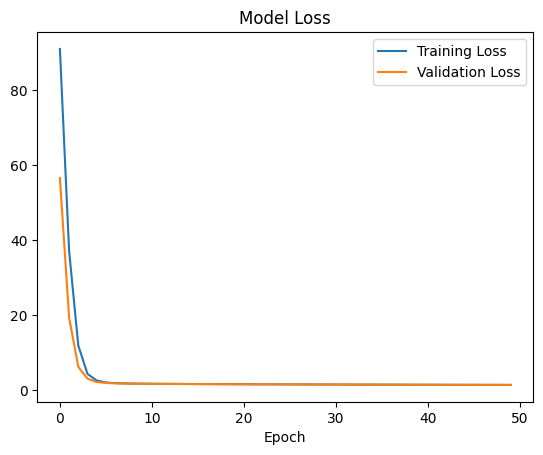

In [14]:
# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [15]:

# Perform predictions on the test set
predictions = model.predict(images)


6/6 [==============================] - 1s 10ms/step


In [16]:
# Convert predictions and true masks to class labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(masks_one_hot, axis=-1)

In [17]:
# Flatten the labels for confusion matrix calculation
predicted_labels_flat = predicted_labels.flatten()
true_labels_flat = true_labels.flatten()


In [18]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
confusion_mat = confusion_matrix(true_labels_flat, predicted_labels_flat)


In [19]:
# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [21]:
model.save('/content/drive/MyDrive/files/unet.h5')

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
confusion_mat = confusion_matrix(true_labels_flat, predicted_labels_flat)



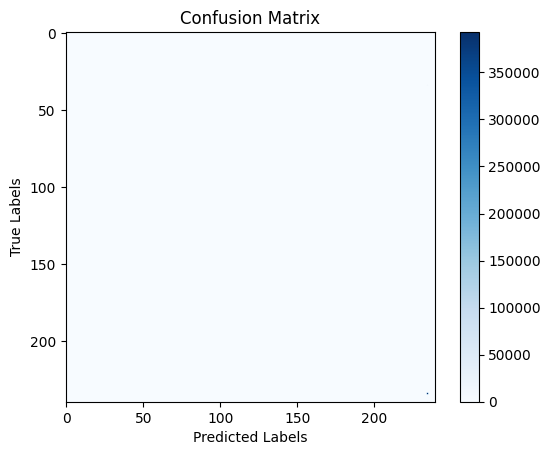

In [23]:
# Plot the confusion matrix as a heatmap
plt.imshow(confusion_mat, cmap='Blues')

# Add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add colorbar
plt.colorbar()

# Show the plot
plt.show()

precision 
recall
f1 score
display images and masks